In [2]:
import pandas as pd

In [3]:
import_file = 'userReview.json'
review = pd.read_json(import_file, lines=True)

In [4]:
review

,business_id,latitude,longitude,review_count,review_id,stars_x,stars_y,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,55.950875,-3.191463,4,VfBHSwC5Vz_pbFluy07i9Q,5,4.0,cjpdDjZyprfyDG3RlkVG3w
1,Nvi9RLcOdrJvSwcw-ziZQQ,55.945860,-3.206205,4,gieaGL6UEtNGMJRpOPUHjg,5,3.5,cjpdDjZyprfyDG3RlkVG3w
2,uYHaNptLzDLoV_JZ_MuzUA,55.950875,-3.191463,169,3zRpneRKDsOPq92tq7ybAA,3,4.0,bjTcT8Ty4cJZhEOEo01FGA
3,D2smJ2r0RrVoe0aGlT-2wA,55.952860,-3.198621,169,BVwTKOMnEevDQI8n_CHjGg,5,3.5,bjTcT8Ty4cJZhEOEo01FGA
4,6Kl2SQp-zGo-nsdImLykxw,55.949990,-3.188796,169,X3dAS9SjWLi25zexhZtOQA,5,4.0,bjTcT8Ty4cJZhEOEo01FGA
5,WbddSfX26mRGXpyuy2ClYQ,45.501846,-73.558826,169,mpajk91608DKrZdvHLt7KA,5,4.0,bjTcT8Ty4cJZhEOEo01FGA
6,sQS0mRR_N-K3lzV8v3DFcw,55.948890,-3.186663,169,4xts4YYUJNAE40rocQc_jA,5,4.0,bjTcT8Ty4cJZhEOEo01FGA
7,um_o0pxQ3DlRI9EfCzw0hw,45.511072,-73.565886,169,Ockks8bbodc8GySKStpF2Q,5,4.5,bjTcT8Ty4cJZhEOEo01FGA
8,Eho3fnzWStx4YgXkhbVNQQ,55.950736,-3.190259,169,6-rJWGMHGyJLusWK0svZrw,5,4.5,bjTcT8Ty4cJZhEOEo01FGA
9,xNpD5ObRmK0q87f6QU283A,45.501225,-73.559362,169,z6O-NERFYyYB2SbkJgoanA,5,3.5,bjTcT8Ty4cJZhEOEo01FGA


In [33]:
users = review['user_id'].drop_duplicates()

In [41]:
users

0          cjpdDjZyprfyDG3RlkVG3w
2          bjTcT8Ty4cJZhEOEo01FGA
13         AXgRULmWcME7J6Ix3I--ww
22         oU2SSOmsp_A8JYI7Z2JJ5w
27         0xtbPEna2Kei11vsU-U2Mw
28         rW8q706dz5-NnXDzMwVkiw
32         yx8vNXUL0D0HS8rUIC7AFA
42         zXnH6W74FAJQ7q7b-NuBsA
55         c5yp5hxwC1N98MjbV2LyWQ
62         xJisL5w4wOgiYLokGMT_IA
64         tgV6tsYQ66DZ3LQKvtC6cw
79         Q-3YCVywc03w56wYtGlKvg
85         Cx4UCow0zQgFQOp47RRRaA
87         eqWEgMH-DCP74i82BEAZzw
248        d0DGZRp6lHXGECJSc_nn-A
253        IpLZ7RevQrFPJWYc9Gxymg
327        kzyLOqiJvyw_FWFTw2rjiQ
329        WZXp9-V2dqRRJqhGgRqueA
394        XylT12exfdLiI_3uDLVIpw
497        Ji9PeffxjwqPLO7pEfSpKQ
572        TLIWzAJPrET0zX4_vgvLhg
617        JZEiTNWBwmv6MOOXYCAaMQ
622        E56sVQT5-OWfSejJrma8_w
630        4WYICo4emecA9r7sPYQkBw
633        P8mVj7AZwJTFFH5FXbbmUg
638        7Y4NEBQqWg7j-TvrQi6UZQ
642        vgZqQqe8cj6SBMH0EqDliw
671        O7G_c6wFXSygr82qs0GAcA
685        UG4EKu13JRwzRix6ESINdg
1204       ZZG

In [34]:
print('Total Number of Users: %d' % len(users))

Total Number of Users: 1183362


In [19]:
import reverse_geocoder as rg
latitude = review['latitude']
longitude = review['longitude']
areas = []

for i in range(4000):
    coordinates = (latitude[4000000+i],longitude[4000000+i])
    results = rg.search(coordinates)
    location = results[0]['admin1']
    if location not in areas:
        areas.append(location)
        print '%s' % (results[0]['admin1'])

Arizona
North Carolina
Nevada
Wisconsin
Pennsylvania
Illinois
Ohio
Ontario
South Carolina
Quebec
Baden-Wuerttemberg
Scotland
North Rhine-Westphalia
California
Florida


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

In [86]:
def user_locations(user):
    user = [user]
    tmp = review.query('user_id == @user').reset_index(drop=True)
    print('User: %s' % user)
    print('Reviews Included: %d' % len(tmp))
    print('Total Reviews: %d' % tmp['review_count'][0])
    return tmp['latitude'], tmp['longitude']

In [87]:
loc = user_locations('eqWEgMH-DCP74i82BEAZzw')

User: ['eqWEgMH-DCP74i82BEAZzw']
Reviews Included: 161
Total Reviews: 359


In [98]:
def locate(latitudes, longitudes):
    X_train = []
    for i in range(len(latitudes)):
        X_train.append([latitudes[i],longitudes[i]])
    X_train = np.array(X_train)

    # fit a Gaussian Mixture Model with one component
    clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
    clf.fit(X_train)
    center = clf.means_[0]
    
    # print location
    coordinates = (center[0], center[1])
    results = rg.search(coordinates)[0]
    
    print('User is located at: %s, %s' % (center[0],center[1]))
    print('%s, %s' % (results['name'],results['admin1']))
    
    # display predicted scores by the model as a contour plot
    x = np.linspace(43.5, 43.9)
    y = np.linspace(-79.1, -78.7)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.title('Businesses Visited by User')
    plt.axis('tight')
    plt.show()
    
    
    return center

User is located at: 43.7318387436, -78.9185786612
Ajax, Ontario


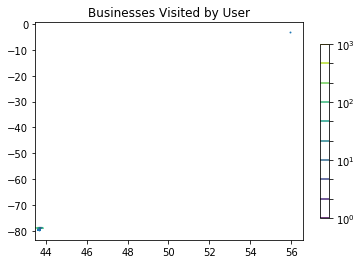

In [99]:
center = locate(loc[0],loc[1])

In [85]:
center[1]

-78.918578661191333